# Calculate, save and plot various skill scores and their ranking

To do for tutorial: also merge functionalities Fien introduced in skill_scores_domain.ipynb

In [3]:
import xarray as xr
from datatree import DataTree
import matplotlib.pyplot as plt
import os
import valenspy as vp
from valenspy.processing.select import select_point

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)


## 0. Load single point simulation

In [6]:
# define points to abstract (lon, lat)
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
}

point_id = "betrix"
point_coord = d_point_coords[point_id]

In [22]:
# define function to load a single point simulation

def load_point_exp_ref(variable, model, ref_dataset, experiments, point_coord):

    ds_obs = manager.load_data(ref_dataset, variable, period=[1995,1995], freq="hourly", region="europe")

    if variable in ['tas','clt', 'clh', 'clm', 'cll']:
        daily_statistic = "mean"
        ds_obs = ds_obs.resample(time='1D').mean()

    elif variable == 'pr': 
 
        daily_statistic = "sum"
        ds_obs = ds_obs.resample(time='1D').sum()

    elif variable == "tasmax": 
        daily_statistic = "max"
        ds_obs = ds_obs.resample(time='1D').max()
   

    # for both datasets, select summer months (JJA)
    ds_obs = ds_obs.sel(time=ds_obs.time.dt.month.isin([6,7,8]))

    # make sure both Datasets have the same daily time axis
    ds_obs['time'] = ds_obs['time'].dt.floor('D')

    # do point selection
    ds_obs_point = select_point(ds_obs, point_coord)

    ds_obs = ds_obs_point.compute()

    if len(experiments)>1:
        d_da_mod = {}


        for experiment in experiments: 
            ds_mod = manager.load_data(model, [variable], freq="daily", path_identifiers=[experiment, daily_statistic])

            ds_mod = ds_mod.sel(time=ds_mod.time.dt.month.isin([6,7,8]))

            ds_mod['time'] = ds_mod['time'].dt.floor('D')

            ds_mod_point = select_point(ds_mod, point_coord, rotated_pole=True)

            da_mod = ds_mod_point[variable].compute()

            d_da_mod[experiment] = da_mod
        
        # make datatree from experiments
        dt_mod = DataTree.from_dict(d_da_mod)

        return ds_obs,dt_mod

    else: 
        experiment = experiments[0]
        ds_mod = manager.load_data(model, [variable], freq="daily", path_identifiers=[experiment, daily_statistic])

        ds_mod = ds_mod.sel(time=ds_mod.time.dt.month.isin([6,7,8]))

        ds_mod['time'] = ds_mod['time'].dt.floor('D')

        ds_mod_point = select_point(ds_mod, point_coord, rotated_pole=True)

        ds_mod = ds_mod_point.compute()

        return ds_obs,da_mod



## 2. Skill score calculation example 
in this example we select one reference database, one variable and three experiments for which the skill scores are calculated

In [23]:
from valenspy.diagnostic_visualizations import plot_metric_ranking
from valenspy.diagnostic_functions import calc_metrics_dt, _add_ranks_metrics, root_mean_square_error


Load point modelled data and observations

In [24]:
# settings
ref_dataset = 'ERA5'
variable = 'tas'
model = 'CCLM'
experiments = [ "BE28_Nick",  "BE28_Ruben"]

# load point observations and model experiments as a data tree
ds_obs, dt_mod =  load_point_exp_ref(variable, model, ref_dataset, experiments, point_coord)

dt_mod

File paths found:
/dodrio/scratch/projects/2022_200/external/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/BE28_Nick/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/BE28_Ruben/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


DataTree('None', parent=None)
├── DataTree('BE28_Nick')
│       Dimensions:    (time: 92)
│       Coordinates:
│         * time       (time) datetime64[ns] 736B 1995-06-01 1995-06-02 ... 1995-08-31
│           lon        float32 4B 5.264
│           lat        float32 4B 49.84
│           rlon       float32 4B 0.662
│           rlat       float32 4B -0.638
│           height_2m  float32 4B 2.0
│       Data variables:
│           tas        (time) float32 368B 284.1 285.4 287.3 285.3 ... 283.7 285.4 286.4
└── DataTree('BE28_Ruben')
        Dimensions:    (time: 92)
        Coordinates:
          * time       (time) datetime64[ns] 736B 1995-06-01 1995-06-02 ... 1995-08-31
            lon        float32 4B 5.265
            lat        float32 4B 49.84
            rlon       float32 4B 0.662
            rlat       float32 4B -0.638
            height_2m  float32 4B 2.0
        Data variables:
            tas        (time) float32 368B 282.6 284.0 285.3 284.9 ... 283.3 284.9 285.4

Calculate one metric (eg root mean square error)

In [26]:
# get the data array from the data tree. 
da_mod = dt_mod[experiments[0]][variable]


rmse = root_mean_square_error(da_mod, ds_obs[variable])

rmse

1.5676940492639977

Calculate various metrics, saved in pandas dataframe

In [27]:
# calculate the metrics
df_metric      = calc_metrics_dt(dt_mod, ds_obs)
df_metric

,member,variable,metric,value,rank
0,BE28_Nick,tas,PSS,1.0,1.0
1,BE28_Ruben,tas,PSS,1.0,1.0
2,BE28_Nick,tas,mae_10pctl,0.02883,1.0
3,BE28_Ruben,tas,mae_10pctl,0.057745,2.0
4,BE28_Nick,tas,mae_1pctl,0.328214,2.0
5,BE28_Ruben,tas,mae_1pctl,0.271425,1.0
6,BE28_Nick,tas,mae_90pctl,0.293357,1.0
7,BE28_Ruben,tas,mae_90pctl,1.290373,2.0
8,BE28_Nick,tas,mae_99pctl,1.164153,1.0
9,BE28_Ruben,tas,mae_99pctl,1.472369,2.0


Calculate the ranking of those metrics ( 1- best to 3 - worst)

In [28]:
df_ranks = _add_ranks_metrics(df_metric)
df_ranks

,member,variable,metric,value,rank
0,BE28_Nick,tas,PSS,1.0,1.0
1,BE28_Ruben,tas,PSS,1.0,1.0
2,BE28_Nick,tas,mae_10pctl,0.02883,1.0
3,BE28_Ruben,tas,mae_10pctl,0.057745,2.0
4,BE28_Nick,tas,mae_1pctl,0.328214,2.0
5,BE28_Ruben,tas,mae_1pctl,0.271425,1.0
6,BE28_Nick,tas,mae_90pctl,0.293357,1.0
7,BE28_Ruben,tas,mae_90pctl,1.290373,2.0
8,BE28_Nick,tas,mae_99pctl,1.164153,1.0
9,BE28_Ruben,tas,mae_99pctl,1.472369,2.0


Plot the ranks in a heatmap

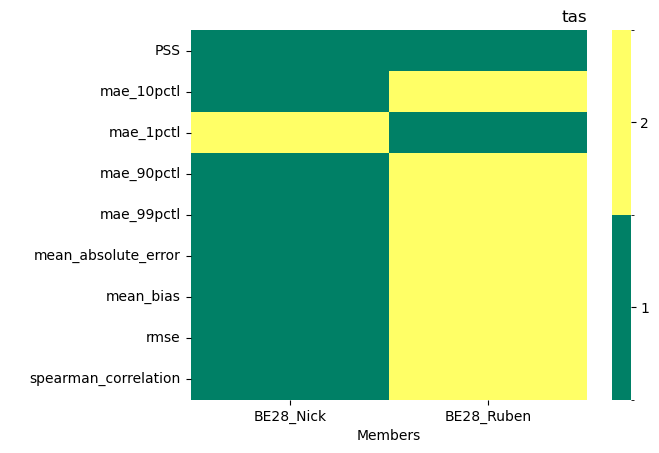

In [29]:
# calculate and plot the ranking of this metric

ax = plot_metric_ranking(df_metric, title=variable)


## 3. Skill score calculation example: multiple variables, saving of metrics as csv and plotting
Here, the metrics are saved in a csv path in the /output directory, which is not tracked by git

In [32]:
ref_dataset = 'ERA5'
variables = ['tas', 'clt']
model = 'CCLM'

experiments = [ "BE28_Nick", "BE28_Ruben"]

d_df_metric_rank = {}
d_df_metric = {}

for variable in variables: 
    ds_obs, dt_mod =  load_point_exp_ref(variable, model, ref_dataset, experiments, point_coord)
    
    # name of csv file
    # retrieve the dataset name from the da attribute in the datatree
    dataset = dt_mod[list(dt_mod.groups)[1]][list(dt_mod[list(dt_mod.groups)[1]].keys())[0]].dataset
    outdir = "../output"
    if not os.path.exists(outdir):
      os.makedirs(outdir)

    csv_path = f"{outdir}/metrics_{point_id}_{variable}_{da_obs.dataset}_{dataset}_.csv"
    df_metric      = calc_metrics_dt(dt_mod, ds_obs)
    df_metric.to_csv(csv_path)
    df_metric_rank = get_ranks_metrics(df_metric)

    d_df_metric_rank[variable] =  df_metric_rank
    d_df_metric[variable]      =  df_metric

File paths found:
/dodrio/scratch/projects/2022_200/external/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/BE28_Nick/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/BE28_Ruben/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


NameError: name 'os' is not defined

 Plotting example with customized plot script (more variables)

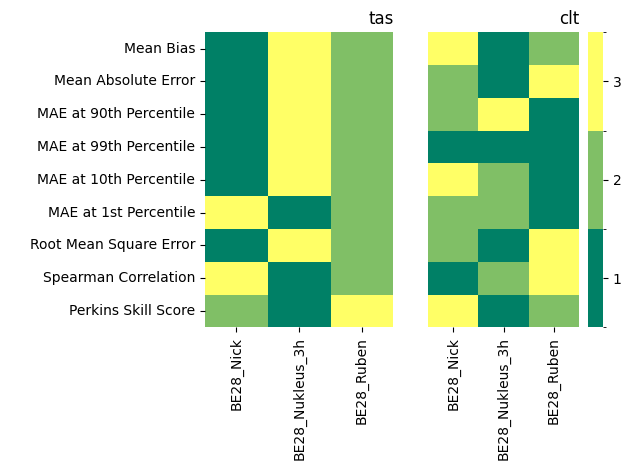

In [16]:


fig, axes = plt.subplots(1,len(variables))
axes = axes.flatten()

for i,variable in enumerate(variables): 
    ax = axes[i]
    df_metric = d_df_metric[variable] 

    if i == 0: 
        ax = plot_metric_ranking(df_metric, ax=ax, title=variable, plot_colorbar=False)
        ax.set_ylabel(' ')

    else:
        ax = plot_metric_ranking(df_metric, ax=ax, title=variable, plot_colorbar=True)

        ax.set_yticks([])
    
fig.tight_layout()

## 4. Showcase Perkins Skill score

Showcase if individual skill score calculation and how the Perkins skill score works

In [14]:
from valenspy.diagnostic_functions import get_userdefined_binwidth, optimal_bin_width
from valenspy.diagnostic_visualizations import visualize_perkins_skill_score


In [18]:
# load some data

# settings
ref_dataset = 'ERA5'
variable = 'tas' 
model = 'CCLM'
experiments = ["BE28_Ruben"]

# load point observations and model experiments as a data array
ds_obs, da_mod =  load_point_exp_ref(variable, model, ref_dataset, experiments, point_coord)

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/BE28_Ruben/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


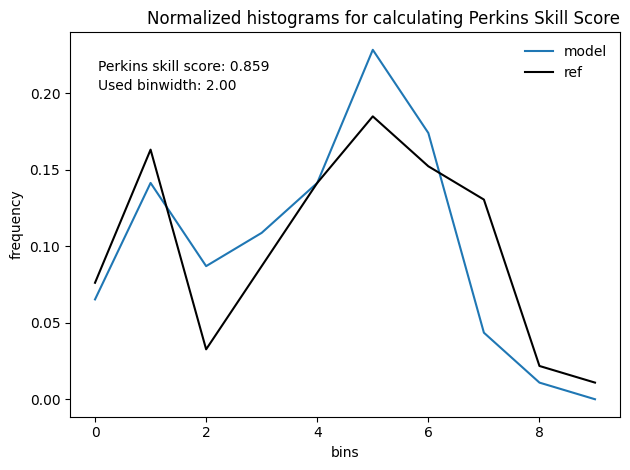

In [19]:
binwidth = get_userdefined_binwidth(variable)  # Replace `None` with actual variable if needed

visualize_perkins_skill_score(da_mod, ds_obs[variable], binwidth= binwidth)


## 5. Example Kobe with the Diagnostic object

In [ ]:
import valenspy as vp
from dask.diagnostics import ProgressBar
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
from datatree import DataTree

In [ ]:
import datatree

dt = datatree.open_datatree("/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/ValEnsPy/notebooks/intermediate_data/preprocessed_data_2006_ERA5_all_1004.nc", chunks="auto")

In [ ]:
dt = dt.sel(time=slice("2006-05-01","2006-06-01")) #Ensuring the data covers the same period
dt = dt.map_over_subtree(lambda x: x[["tas"]])
dt

DataTree('None', parent=None)
├── DataTree('obs')
│   └── DataTree('ERA5')
│           Dimensions:  (time: 768, lat: 141, lon: 221)
│           Coordinates:
│             * lon      (lon) float32 884B -15.0 -14.75 -14.5 -14.25 ... 39.5 39.75 40.0
│             * lat      (lat) float32 564B 35.0 35.25 35.5 35.75 ... 69.25 69.5 69.75 70.0
│             * time     (time) datetime64[ns] 6kB 2006-05-01 ... 2006-06-01T23:00:00
│           Data variables:
│               tas      (time, lat, lon) float64 191MB dask.array<chunksize=(624, 55, 87), meta=np.ndarray>
│           Attributes:
│               Conventions:  CF-1.6
│               history:      2020-02-19 04:37:50 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
│               period:       2006
│               freq:         hourly
│               region:       europe
│               dataset:      ERA5
└── DataTree('mod')
    ├── DataTree('ALARO_original')
    │       Dimensions:  (time: 768, lat: 141, lon: 221)
    │       Coordinates:
    │         * time     (time) datetime64[ns] 6kB 2006-05-01 ... 2006-06-01T23:00:00
    │         * lon      (lon) float64 2kB -15.0 -14.75 -14.5 -14.25 ... 39.5 39.75 40.0
    │         * lat      (lat) float64 1kB 35.0 35.25 35.5 35.75 ... 69.25 69.5 69.75 70.0
    │       Data variables:
    │           tas      (time, lat, lon) float32 96MB dask.array<chunksize=(373, 141, 221), meta=np.ndarray>
    │       Attributes: (12/23)
    │           ey:           13
    │           dy:           12500
    │           projection:   lcc
    │           center_lon:   9.9
    │           origin:       /dodrio/scratch/projects/2022_200/project_output/RMIB-UGent...
    │           dx:           12500
    │           ...           ...
    │           history:      Thu Oct 03 17:16:01 2024: cdo -O -s -f nc -remapbil,/dodrio...
    │           center_lat:   49
    │           validate:     2006-01-02 01:00:00
    │           timestep:     300
    │           basedate:     2006-01-01
    │           proj_R:       6371229
    ├── DataTree('ALARO_GHGs')
    │       Dimensions:  (time: 768, lat: 141, lon: 221)
    │       Coordinates:
    │         * time     (time) datetime64[ns] 6kB 2006-05-01 ... 2006-06-01T23:00:00
    │         * lon      (lon) float64 2kB -15.0 -14.75 -14.5 -14.25 ... 39.5 39.75 40.0
    │         * lat      (lat) float64 1kB 35.0 35.25 35.5 35.75 ... 69.25 69.5 69.75 70.0
    │       Data variables:
    │           tas      (time, lat, lon) float32 96MB dask.array<chunksize=(349, 141, 221), meta=np.ndarray>
    │       Attributes: (12/23)
    │           ey:           13
    │           dy:           12500
    │           projection:   lcc
    │           center_lon:   9.9
    │           origin:       /dodrio/scratch/projects/2022_200/project_output/RMIB-UGent...
    │           dx:           12500
    │           ...           ...
    │           history:      Wed Oct 02 15:23:13 2024: cdo -O -s -f nc -remapbil,/dodrio...
    │           center_lat:   49
    │           validate:     2006-01-01 01:00:00
    │           timestep:     300
    │           basedate:     2006-01-01
    │           proj_R:       6371229
    ├── DataTree('ALARO_GHGs_v2')
    │       Dimensions:  (time: 768, lat: 141, lon: 221)
    │       Coordinates:
    │         * time     (time) datetime64[ns] 6kB 2006-05-01 ... 2006-06-01T23:00:00
    │         * lon      (lon) float64 2kB -15.0 -14.75 -14.5 -14.25 ... 39.5 39.75 40.0
    │         * lat      (lat) float64 1kB 35.0 35.25 35.5 35.75 ... 69.25 69.5 69.75 70.0
    │       Data variables:
    │           tas      (time, lat, lon) float32 96MB dask.array<chunksize=(349, 141, 221), meta=np.ndarray>
    │       Attributes: (12/23)
    │           ey:           13
    │           dy:           12500
    │           projection:   lcc
    │           center_lon:   9.9
    │           origin:       /dodrio/scratch/projects/2022_200/project_output/RMIB-UGent...
    │           dx:           12500
    │           ...   

In [ ]:
from valenspy.diagnostic import MetricsRankings
out = MetricsRankings.apply(dt.mod, dt.obs.ERA5.to_dataset(), pss_binwidth=2)
out

,member,variable,metric,value,rank
0,ALARO_original,tas,PSS,1.0,1.0
1,ALARO_GHGs,tas,PSS,1.0,1.0
2,ALARO_GHGs_v2,tas,PSS,1.0,1.0
3,ALARO_AERO0920_GMTED30,tas,PSS,1.0,1.0
4,ALARO_AERO0920_GMTED30_RMICLIM,tas,PSS,1.0,1.0
5,ALARO_AERO0911_GMTED30_RMICLIM,tas,PSS,1.0,1.0
6,ALARO_original,tas,mae_10pctl,1.935799,4.0
7,ALARO_GHGs,tas,mae_10pctl,1.649901,1.0
8,ALARO_GHGs_v2,tas,mae_10pctl,2.0278,6.0
9,ALARO_AERO0920_GMTED30,tas,mae_10pctl,1.898802,2.0


<Axes: title={'right': 'tas'}, xlabel='Members', ylabel=' '>

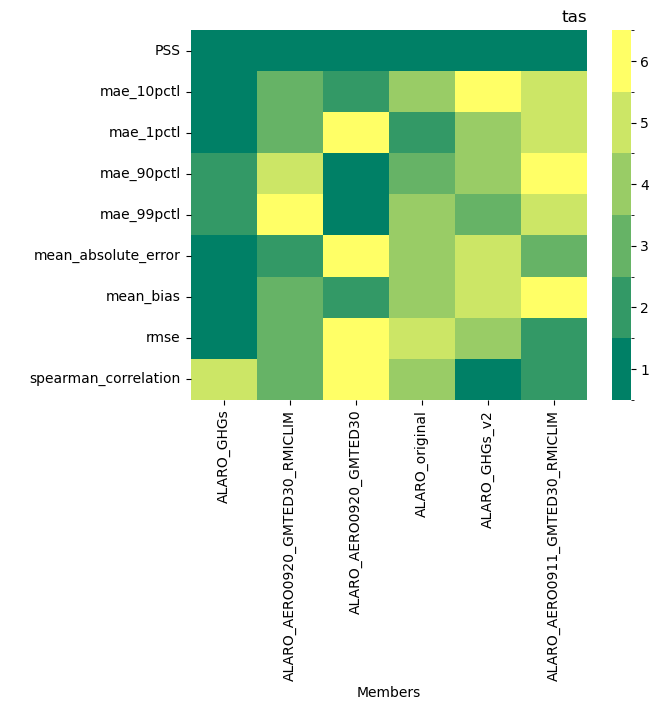

In [ ]:
MetricsRankings.plot(out, title="tas")

## 6. Test functionalities of skill score calculations whether they work on multiple dimensions


In [4]:
from valenspy.diagnostic_functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score
from valenspy.preprocessing_tasks.regrid import remap_cdo


In [5]:
# load observations and model simulations for different variables. (with lat lon time dimensions)

ref_dataset = 'ERA5'
variables = ['tas']
variable = variables[0]
model = 'CCLM'
experiment = "BE28_Ruben"

ds_obs = manager.load_data(ref_dataset, variables, period=[1995,1995], freq="hourly", region="europe")
gridfile = manager._get_file_paths(ref_dataset, variables, period=[1995,1995], freq="hourly", region="europe")[0]

if variable in ['tas','clt', 'clh', 'clm', 'cll']:
    daily_statistic = "mean"
    ds_obs = ds_obs.resample(time='1D').mean()

elif variable == 'pr': 

    daily_statistic = "sum"
    ds_obs = ds_obs.resample(time='1D').sum()

elif variable == "tasmax": 
    daily_statistic = "max"
    ds_obs = ds_obs.resample(time='1D').max()


# for both datasets, select summer months (JJA)
ds_obs = ds_obs.sel(time=ds_obs.time.dt.month.isin([6,7,8]))

# make sure both Datasets have the same daily time axis
ds_obs['time'] = ds_obs['time'].dt.floor('D')

ds_mod = manager.load_data(model, variables, freq="daily", path_identifiers=[experiment, daily_statistic])

ds_mod = ds_mod.sel(time=ds_mod.time.dt.month.isin([6,7,8]))

ds_mod['time'] = ds_mod['time'].dt.floor('D')

ds_mod = remap_cdo(gridfile, ds_mod, remap_method="con")



File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/BE28_Ruben/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


In [8]:
mae = mean_absolute_error(ds_mod[variable], ds_obs[variable], percentile = 0.01)
mae

8.675544797177736

In [9]:
bias = mean_bias(ds_mod[variable], ds_obs[variable])
bias

array(-0.14397747)

In [10]:
rmse = root_mean_square_error(ds_mod[variable], ds_obs[variable])
rmse

1.4094665499235115

In [ ]:
corr = spearman_correlation(ds_mod[variable], ds_obs[variable])
corr

1.4094665499235115

In [6]:
pss, _, _, _ = perkins_skill_score(ds_mod[variable], ds_obs[variable])
pss

0.04410540915395284